In [4]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import pathlib
import tree as miptree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from model.threshold_guess import compute_thresholds, cut
from model.gosdt import GOSDT
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
import datetime

%matplotlib inline

In [123]:
df_tran = pd.read_csv('transactions')

In [124]:
df_tran = df_tran.drop(columns=['Unnamed: 0'])

In [125]:
df_tran

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90.0,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,9.0,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,2.0,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,9.0,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


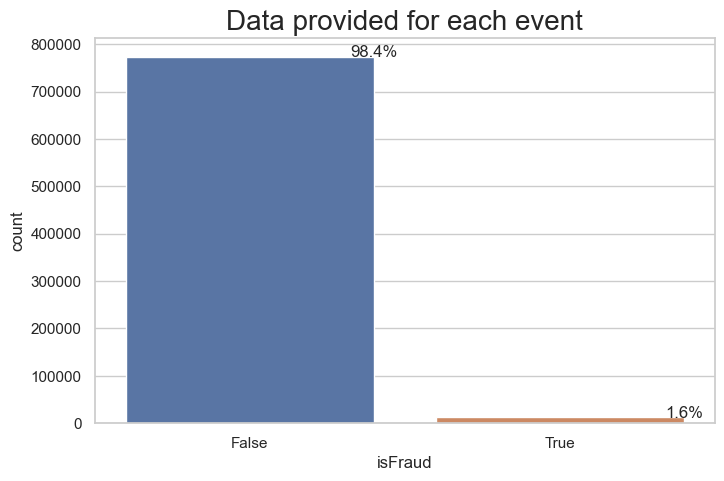

In [126]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df_tran))
ax = sns.countplot(x="isFraud", data=df_tran)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [127]:
df_tran

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90.0,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,732852505,732852505,50000,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,9.0,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,732852505,732852505,50000,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,2.0,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,732852505,732852505,50000,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,9.0,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


### It can be seen that there are some features that have all rows as null so they need to be dropped

In [128]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [129]:
df_tran = df_tran.drop(columns=['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

### Removing features that are highly correlated

/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_72651/2596127890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tran.corr(),cmap='coolwarm')


<AxesSubplot: >

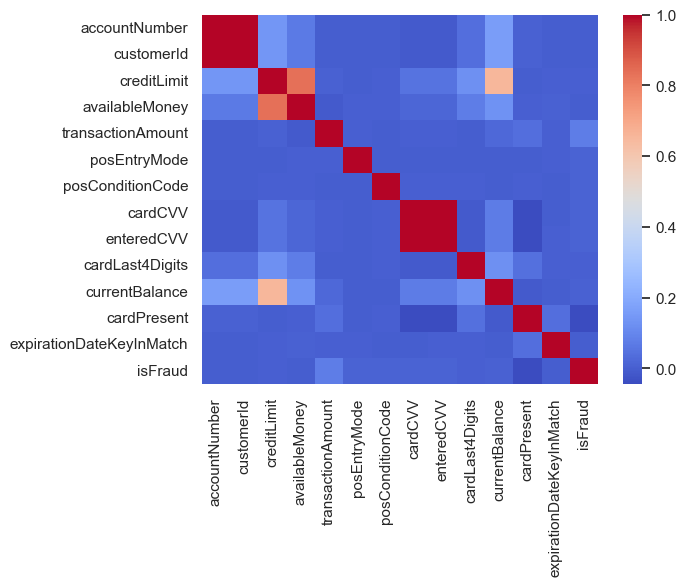

In [130]:
sns.heatmap(df_tran.corr(),cmap='coolwarm')

In [131]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [132]:
df_tran = df_tran.drop(['customerId','availableMoney','accountNumber','merchantName','cardLast4Digits'],axis=1)

/var/folders/sn/1rkb9b6d6676rjdtm6y0sp880000gn/T/ipykernel_72651/2596127890.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_tran.corr(),cmap='coolwarm')


<AxesSubplot: >

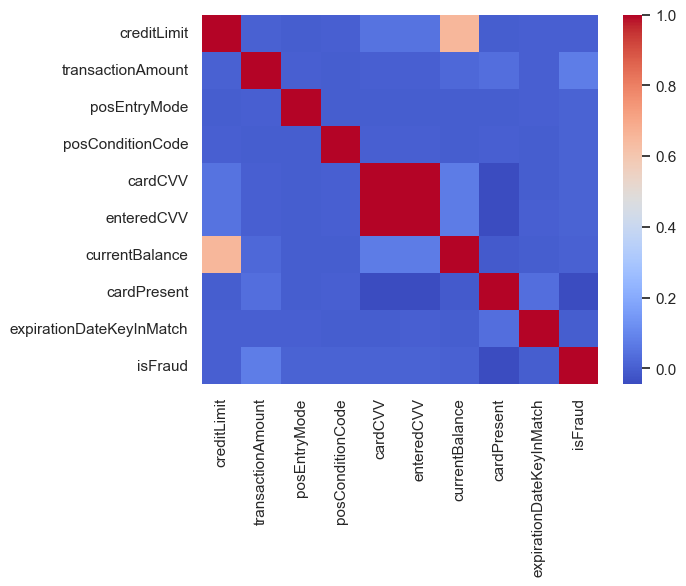

In [133]:
sns.heatmap(df_tran.corr(),cmap='coolwarm')

### Checking for unique values and doing some EDA

### accountNumber, last4digit, merchantName, Make a boolean feature to see if cardCVV matches the enteredCVV

In [150]:
for col in df_tran:
    print(f'{col}: {df_tran[col].nunique()}')

creditLimit: 10
transactionDateTime: 365
transactionAmount: 66038
acqCountry: 4
merchantCountryCode: 4
posEntryMode: 5
posConditionCode: 3
merchantCategoryCode: 19
currentExpDate: 165
accountOpenDate: 1820
dateOfLastAddressChange: 2184
transactionType: 3
currentBalance: 487318
cardPresent: 2
expirationDateKeyInMatch: 2
isFraud: 2
equalCVV: 2


In [135]:
df_tran['equalCVV'] = (df_tran['enteredCVV']==df_tran['cardCVV']).astype(int)

In [136]:
df_tran.equalCVV.value_counts()

1    779348
0      7015
Name: equalCVV, dtype: int64

In [137]:
df_tran = df_tran.drop(columns=['enteredCVV','cardCVV'])

In [138]:
import datetime

df_tran['transactionDateTime'] = pd.to_datetime(df_tran['transactionDateTime'])
df_tran['currentExpDate'] = pd.to_datetime(df_tran['currentExpDate'])
df_tran['accountOpenDate'] = pd.to_datetime(df_tran['accountOpenDate'])
df_tran['dateOfLastAddressChange'] = pd.to_datetime(df_tran['dateOfLastAddressChange'])

In [139]:
first_acc_date = df_tran.accountOpenDate.min()

### Converted date columns to numeric, however, this can also be explored later as making Separate columns for 
### different data columns by using this code

df['transactionDateTime_year'] = df['transactionDateTime'].dt.year
df['transactionDateTime_month'] = df['transactionDateTime'].dt.month
df['transactionDateTime_day'] = df['transactionDateTime'].dt.day
df['transactionDateTime_hour'] = df['transactionDateTime'].dt.hour
df['transactionDateTime_minute'] = df['transactionDateTime'].dt.minute
df['transactionDateTime_second'] = df['transactionDateTime'].dt.second

df['currentExpDate_year'] = df['currentExpDate'].dt.year
df['currentExpDate_month'] = df['currentExpDate'].dt.month
df['currentExpDate_day'] = df['currentExpDate'].dt.day

df['accountOpenDate_year'] = df['accountOpenDate'].dt.year
df['accountOpenDate_month'] = df['accountOpenDate'].dt.month
df['accountOpenDate_day'] = df['accountOpenDate'].dt.day

df['dateOfLastAddressChange_year'] = df['dateOfLastAddressChange'].dt.year
df['dateOfLastAddressChange_month'] = df['dateOfLastAddressChange'].dt.month
df['dateOfLastAddressChange_day'] = df['dateOfLastAddressChange'].dt.day

In [144]:
df_tran['transactionDateTime'] = df_tran['transactionDateTime'] - first_acc_date
df_tran['transactionDateTime'] = df_tran['transactionDateTime'].apply(lambda x : x.days)
df_tran['currentExpDate'] = df_tran['currentExpDate'] - first_acc_date
df_tran['currentExpDate'] = df_tran['currentExpDate'].apply(lambda x : x.days)
df_tran['accountOpenDate'] = df_tran['accountOpenDate'] - first_acc_date
df_tran['accountOpenDate'] = df_tran['accountOpenDate'].apply(lambda x : x.days)
df_tran['dateOfLastAddressChange'] = df_tran['dateOfLastAddressChange'] - first_acc_date
df_tran['dateOfLastAddressChange'] = df_tran['dateOfLastAddressChange'].apply(lambda x : x.days)

### Encoding 

In [157]:
pd.set_option('display.max_columns', None)

df_tran = pd.get_dummies(df_tran)

In [164]:
df_tran['cardPresent'] = df_tran['cardPresent'].astype(int)
df_tran['expirationDateKeyInMatch'] = df_tran['expirationDateKeyInMatch'].astype(int)
df_tran['isFraud'] = df_tran['isFraud'].astype(int)

In [197]:
df_tran = df_tran.dropna()
df_tran

,creditLimit,transactionDateTime,transactionAmount,posEntryMode,posConditionCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,equalCVV,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,5000,9853,98.55,2.0,1.0,12336,9335,9335,0.00,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,5000,9912,74.51,9.0,1.0,12581,9335,9335,0.00,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5000,9940,7.47,9.0,1.0,13128,9335,9335,0.00,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,5000,9972,7.47,9.0,1.0,13128,9335,9335,0.00,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,5000,9711,71.18,2.0,1.0,14650,9480,9480,0.00,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,50000,9984,119.92,90.0,1.0,12154,8402,8402,1095.04,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
786359,50000,9987,18.89,9.0,1.0,12397,8402,8402,1214.96,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
786360,50000,9989,49.43,2.0,1.0,13128,8402,8402,1233.85,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
786361,50000,9991,49.89,9.0,99.0,12001,8402,8402,1283.28,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [192]:
X = df_tran.drop(columns= ['isFraud'])
y = df_tran['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [193]:
print("Before OverSampling, counts of label 'True': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'False': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label 'True': 8497
Before OverSampling, counts of label 'False': 538835 



In [194]:
X_train

,creditLimit,transactionDateTime,transactionAmount,posEntryMode,posConditionCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,currentBalance,cardPresent,expirationDateKeyInMatch,equalCVV,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_PR,merchantCountryCode_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
678476,5000,9692,495.72,2.0,1.0,15107,9619,9685,0.00,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
627609,5000,9931,98.91,9.0,1.0,14862,8821,9827,4041.28,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
235352,15000,9648,292.31,2.0,1.0,15624,8297,8297,1217.09,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
35802,250,9979,340.02,9.0,1.0,15107,9215,9215,217.36,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
241884,5000,9646,114.34,9.0,8.0,12519,9069,9640,3606.17,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361850,15000,9726,106.08,9.0,1.0,15107,9314,9702,12696.66,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
153215,50000,9779,99.47,2.0,1.0,11820,9486,9631,29091.43,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
118672,15000,9970,32.39,9.0,1.0,14102,7131,9954,7707.04,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
438366,7500,9797,353.44,9.0,1.0,13371,7475,9731,3434.70,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [195]:
from imblearn.over_sampling import SMOTENC
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label 'True': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label 'False': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (1077670, 42)
After OverSampling, the shape of train_y: (1077670,) 

After OverSampling, counts of label 'True': 538835
After OverSampling, counts of label 'False': 538835


In [224]:
y_labels_before_SMOTE = pd.DataFrame(y_train)
y_labels_before_SMOTE = y_labels_before_SMOTE.rename(columns={0:'isFraud'})

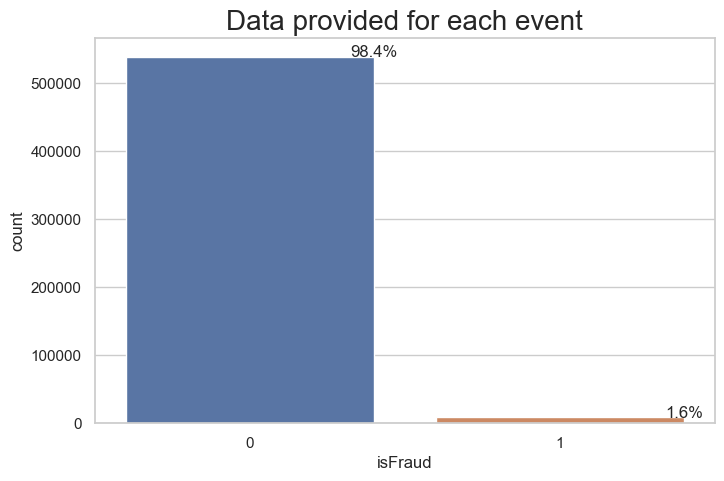

In [225]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(y_labels_before_SMOTE))
ax = sns.countplot(x="isFraud", data=y_labels_before_SMOTE)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [204]:
y_labels = pd.DataFrame(y_train_res)
y_labels = y_labels.rename(columns={0:'isFraud'})

In [217]:
y_labels.value_counts()

isFraud
0          538835
1          538835
dtype: int64

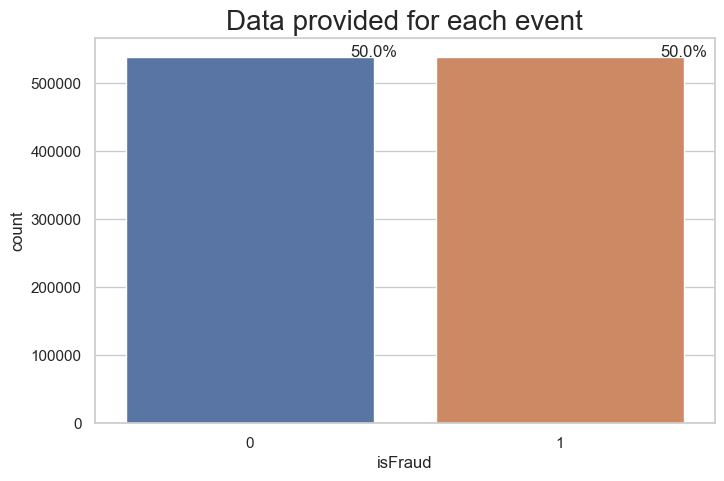

In [219]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(y_labels))
ax = sns.countplot(x="isFraud", data=y_labels)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()